In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile
import h5py

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Read maxIV data

In [2]:
st = 1
ndist = 4
pad = 0
data = np.zeros([ndist,1,2048+2*pad,2048+2*pad],dtype='float32')

with h5py.File('star.h5') as fid:
    for k in range(ndist):
        data[k] = np.pad(fid[f'/data/cpr/00000{k+st}'][:],((pad,pad),(pad,pad)),'edge')

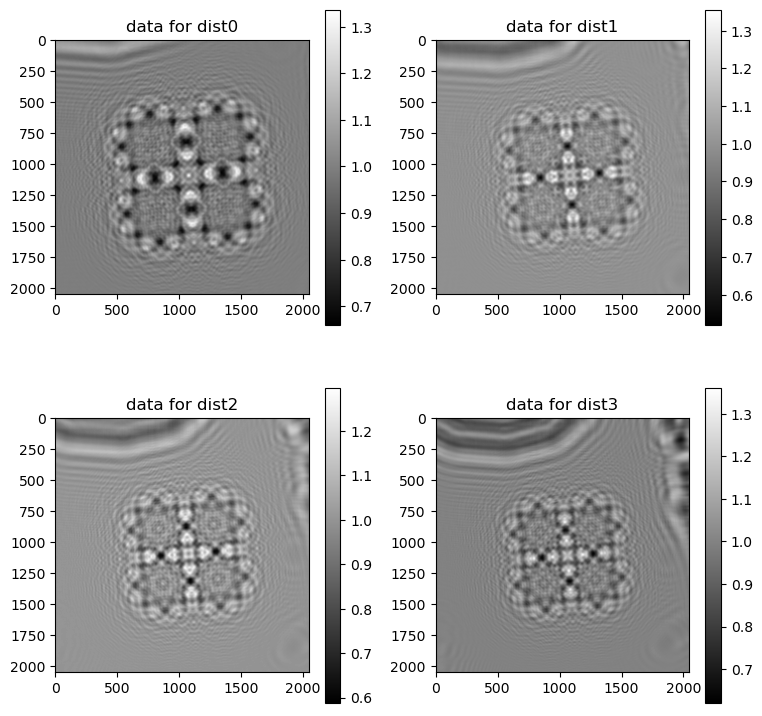

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for dist0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data for dist1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0],cmap='gray')
axs[1,0].set_title('data for dist2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,0],cmap='gray')
axs[1,1].set_title('data for dist3')
fig.colorbar(im)

In [4]:
n = 2048+2*pad  # object size in x,y
nz = 2048+2*pad  # object size in z    
psizes = np.array([0.005924105213429106, 0.006042962789179672,\
0.009222000210157531, 0.009358912996259811,\
0.0105686506240319, 0.010719067864885941,\
0.011316687695029559, 0.011496019888605094,\
0.012108992620241392, 0.012268234280628025])
psizes = psizes.reshape(5,2)
psizes = np.mean(psizes,1)[st:st+ndist]
psizes*=1e-6
voxelsize = psizes[0]
energy = 13  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
distances = np.array([0.010054, 0.0155, 0.0178, 0.019, 0.0203])[st:st+ndist]
norm_magnifications = 1/(psizes/psizes[0])
print(norm_magnifications)

data_scaled=data.copy()
for k in range(ndist):
    a = ndimage.zoom(data[k,0],1/norm_magnifications[k])
    data_scaled[k,0] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]
#norm_magnifications[:]=1

[1.         0.87284662 0.81449837 0.76222424]


## Read data

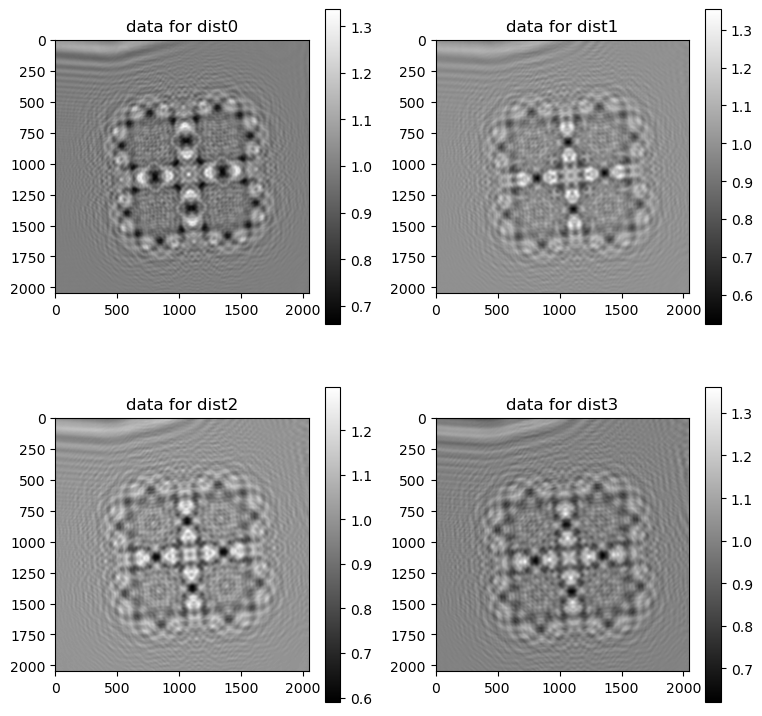

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data_scaled[0,0],cmap='gray')
axs[0,0].set_title('data for dist0')
fig.colorbar(im)
im=axs[0,1].imshow(data_scaled[1,0],cmap='gray')
axs[0,1].set_title('data for dist1')
fig.colorbar(im)
im=axs[1,0].imshow(data_scaled[2,0],cmap='gray')
axs[1,0].set_title('data for dist2')
fig.colorbar(im)
im=axs[1,1].imshow(data_scaled[-1,0],cmap='gray')
axs[1,1].set_title('data for dist3')
fig.colorbar(im)

## Align

[[-12.1  -4.7]]
[[0. 0.]]
[[ 7.7 -0.6]]
[[ 36.3 -14.5]]


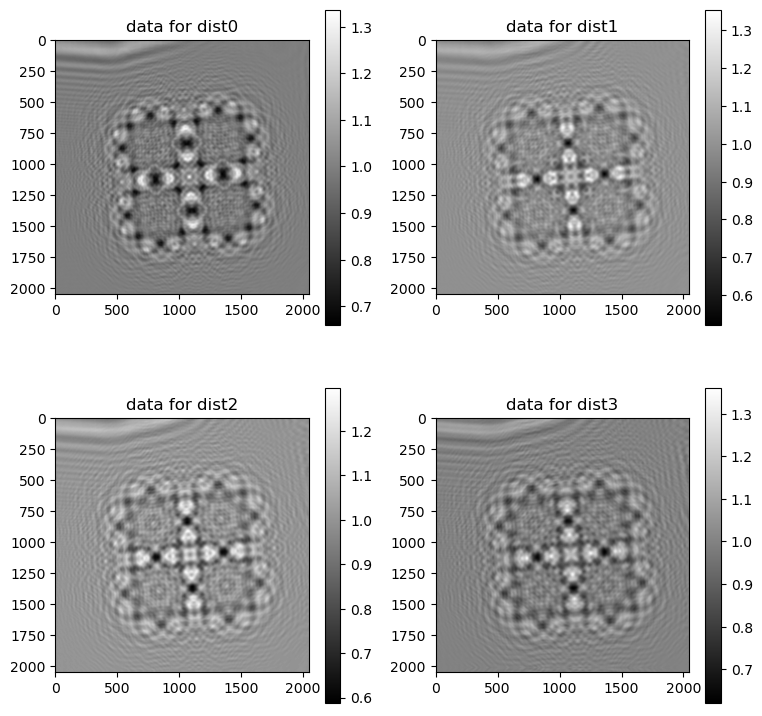

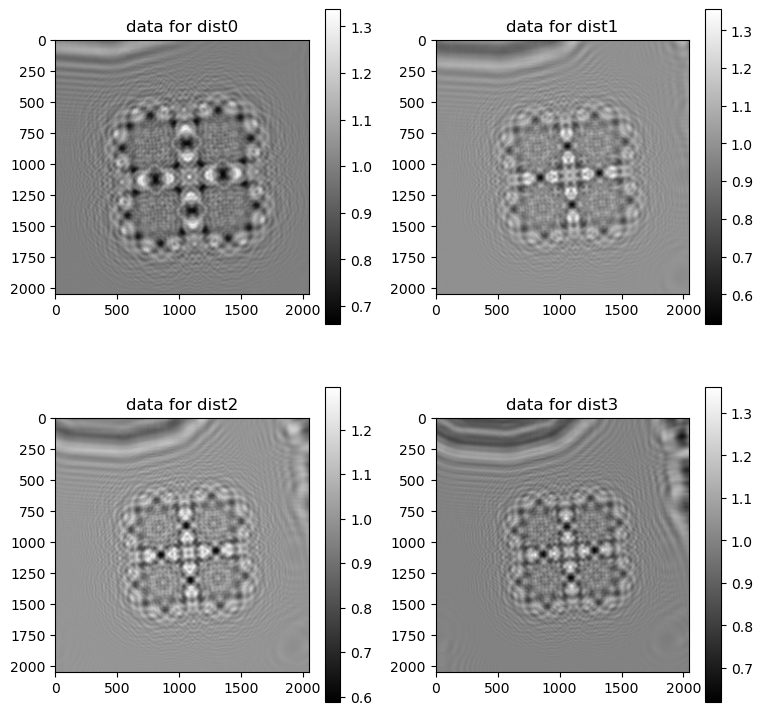

In [6]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    # tmp = np.zeros([psi.shape[0], 2*nz, 2*n], dtype='float32')
    # tmp[:, nz//2:3*nz//2, n//2:3*n//2] = psi
    tmp = np.pad(psi,((0,0),(nz//2,nz//2),(n//2,n//2)), 'symmetric')
    [x, y] = np.meshgrid(np.fft.rfftfreq(2*n),
                         np.fft.fftfreq(2*nz))
    shift = np.exp(-2*np.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = np.fft.irfft2(shift*np.fft.rfft2(tmp))
    res = res0[:, nz//2:3*nz//2, n//2:3*n//2]
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts
data_scaled_new = data_scaled.copy()    
data_new = data.copy()    
for k in range(ndist):
    p = registration_shift(data_scaled[k],data_scaled[1],upsample_factor=10)
    print(p)
    data_scaled_new[k] = apply_shift(data_scaled[k],-p)
    data_new[k] = apply_shift(data[k],-p*norm_magnifications[k])

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data_scaled_new[0,0],cmap='gray')
axs[0,0].set_title('data for dist0')
fig.colorbar(im)
im=axs[0,1].imshow(data_scaled_new[1,0],cmap='gray')
axs[0,1].set_title('data for dist1')
fig.colorbar(im)
im=axs[1,0].imshow(data_scaled_new[2,0],cmap='gray')
axs[1,0].set_title('data for dist2')
fig.colorbar(im)
im=axs[1,1].imshow(data_scaled_new[-1,0],cmap='gray')
axs[1,1].set_title('data for dist3')
fig.colorbar(im)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data_new[0,0],cmap='gray')
axs[0,0].set_title('data for dist0')
fig.colorbar(im)
im=axs[0,1].imshow(data_new[1,0],cmap='gray')
axs[0,1].set_title('data for dist1')
fig.colorbar(im)
im=axs[1,0].imshow(data_new[2,0],cmap='gray')
axs[1,0].set_title('data for dist2')
fig.colorbar(im)
im=axs[1,1].imshow(data_new[-1,0],cmap='gray')
axs[1,1].set_title('data for dist3')
fig.colorbar(im)

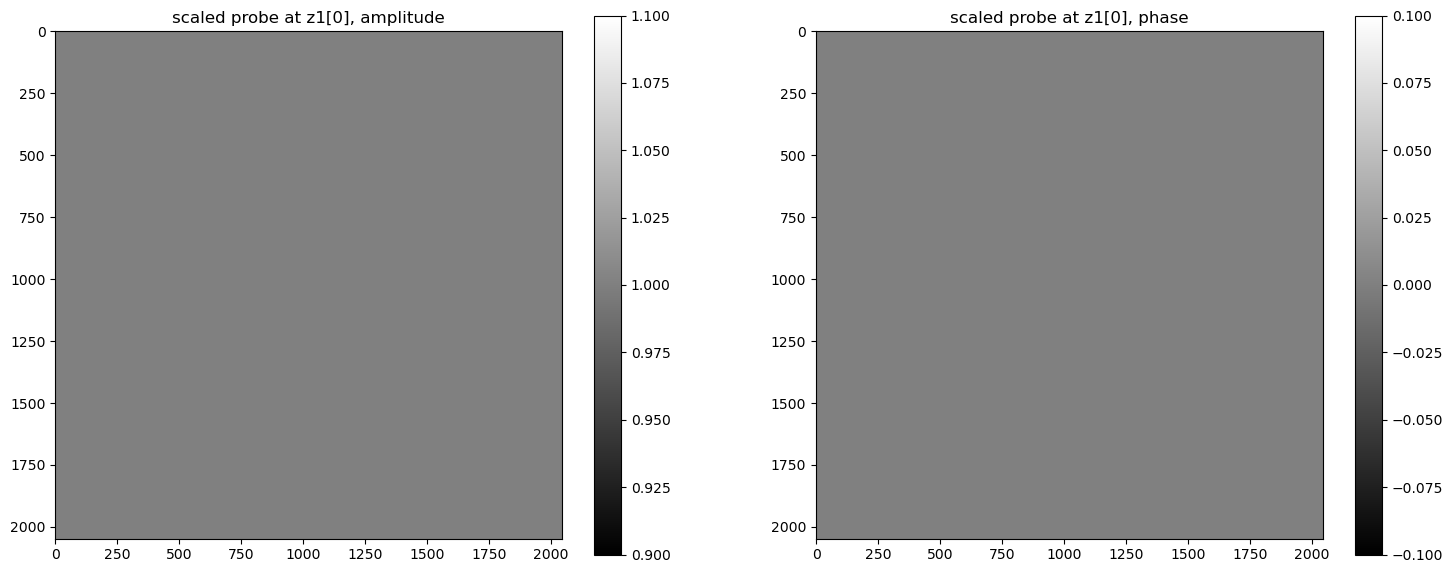

In [7]:
prb = np.ones([ndist,nz,n],dtype='complex64')
# prb[:] = (tifffile.imread(f'data/prb_id16a/prb_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'data/prb_id16a/prb_phase_{n}.tiff')))[0]
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Create a solver class for holography

In [8]:
pslv = holotomo.SolverHolo(1, nz, n, 1, voxelsize, energy, distances, norm_magnifications*0+1) 

## Conjugate gradient solver

In [9]:

import cupy as cp
import numpy as np
import holotomo

def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""
    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(pslv, data, init, prb,  piter, codes=None):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    norm_data = np.linalg.norm(data)
    maxprb = cp.max(cp.abs(prb))
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb,codes)
        grad = pslv.adj_holo(
           fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb, codes)/maxprb**2
        #grad = pslv.adj_holo(
             #(cp.abs(fpsi)**2-data)*fpsi,prb)/maxprb**2
        
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        fd = pslv.fwd_holo(d, prb,codes)
        gamma = line_search(minf, 1, psi, fpsi, d, fd)
        psi = psi + gamma*d
        err=minf(psi,fpsi)
        if i%8==0:
            print(f'{i}) {gamma=}, {err=:1.4e}')    
        
            
    
    return psi

def cg_holo_batch(pslv, data, init, prb, piter, codes=None):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.nz, pslv.n], dtype='complex64')
    prb_gpu = cp.array(prb)            
    if codes is not None:
        codes_gpu = cp.array(codes)
    else:
        codes_gpu=None          
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_gpu, piter, codes_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res


piter = 64 # number of CG iters
init = np.ones([1,nz,n],dtype='complex64')  # initial guess
rec_scaled = cg_holo_batch(pslv, data_scaled_new, init, prb,  piter)

0) gamma=0.5, err=1.4144e+04
8) gamma=1, err=2.7196e+02
16) gamma=0.5, err=2.4818e+02
24) gamma=0.5, err=2.4623e+02
32) gamma=0.5, err=2.4525e+02
40) gamma=0.5, err=2.4455e+02
48) gamma=0.5, err=2.4402e+02
56) gamma=0.5, err=2.4361e+02


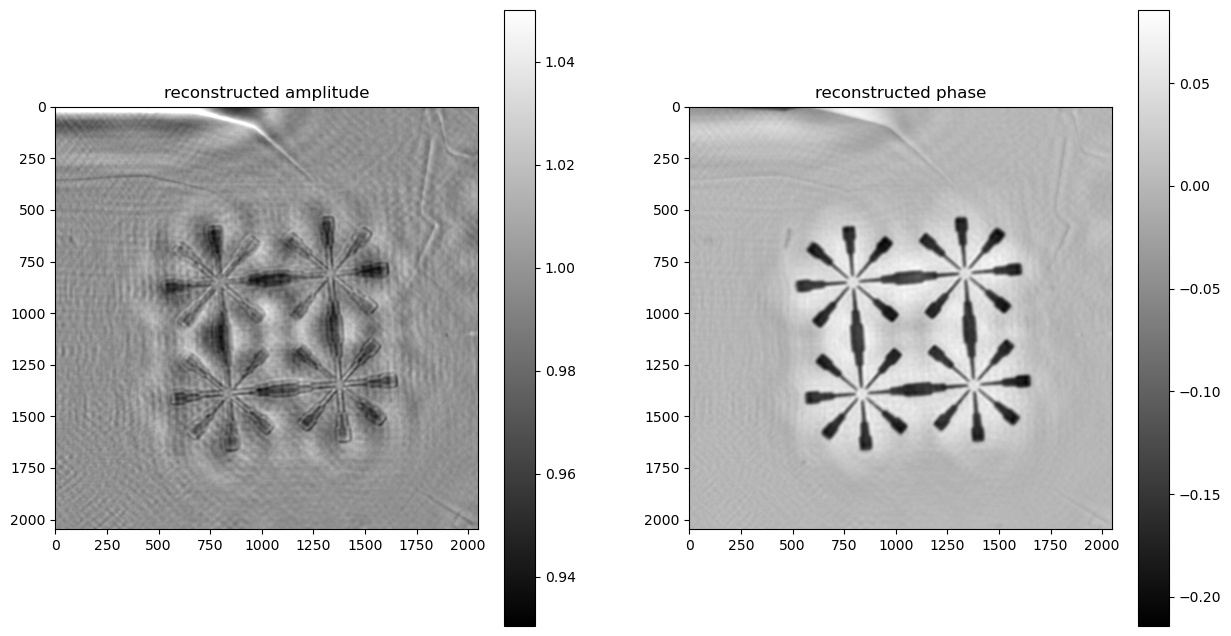

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_scaled[0]),cmap='gray',vmax=1.05)
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_scaled[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

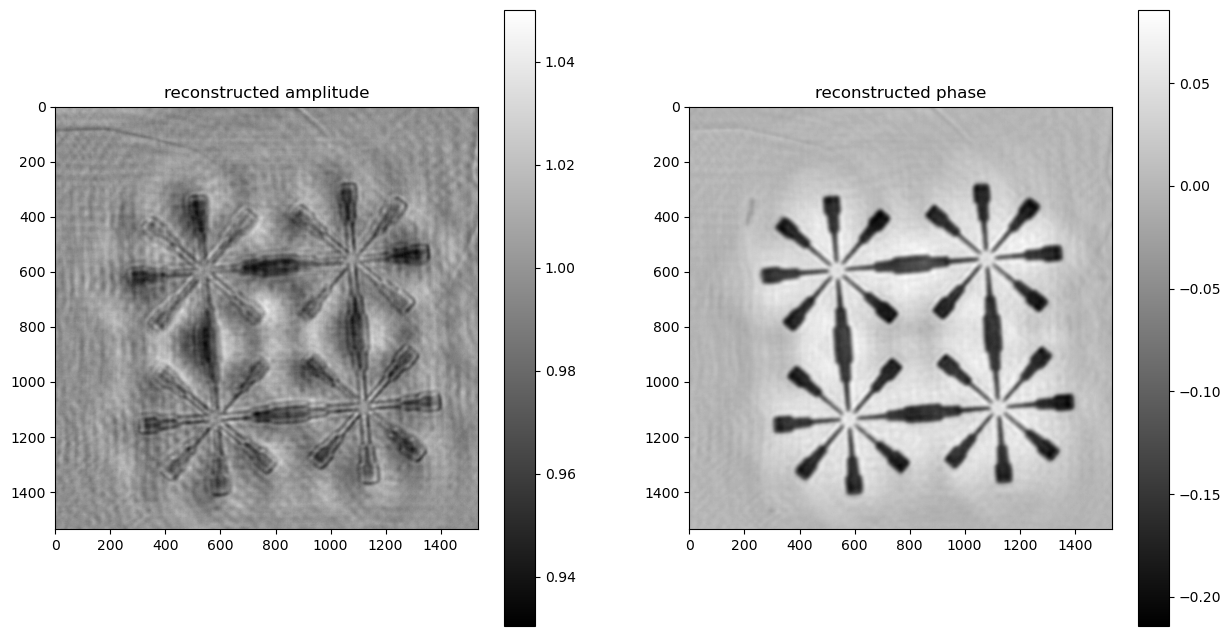

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_scaled[0,256:-256,256:-256]),cmap='gray',vmax=1.05)
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_scaled[0,256:-256,256:-256]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

In [12]:
distances_norm = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes
pslv = holotomo.SolverHolo(1, nz, n, 1, voxelsize, energy, distances_norm, norm_magnifications) 
piter = 64 # number of CG iters
init = np.ones([1,nz,n],dtype='complex64')  # initial guess
rec = cg_holo_batch(pslv, data_new, init, prb,  piter)

0) gamma=0.5, err=1.3007e+04
8) gamma=0.25, err=2.4129e+03
16) gamma=0.25, err=2.1326e+03
24) gamma=0.25, err=2.0684e+03
32) gamma=0.25, err=2.0327e+03
40) gamma=0.5, err=2.0195e+03
48) gamma=0.25, err=2.0067e+03
56) gamma=0.125, err=2.0007e+03


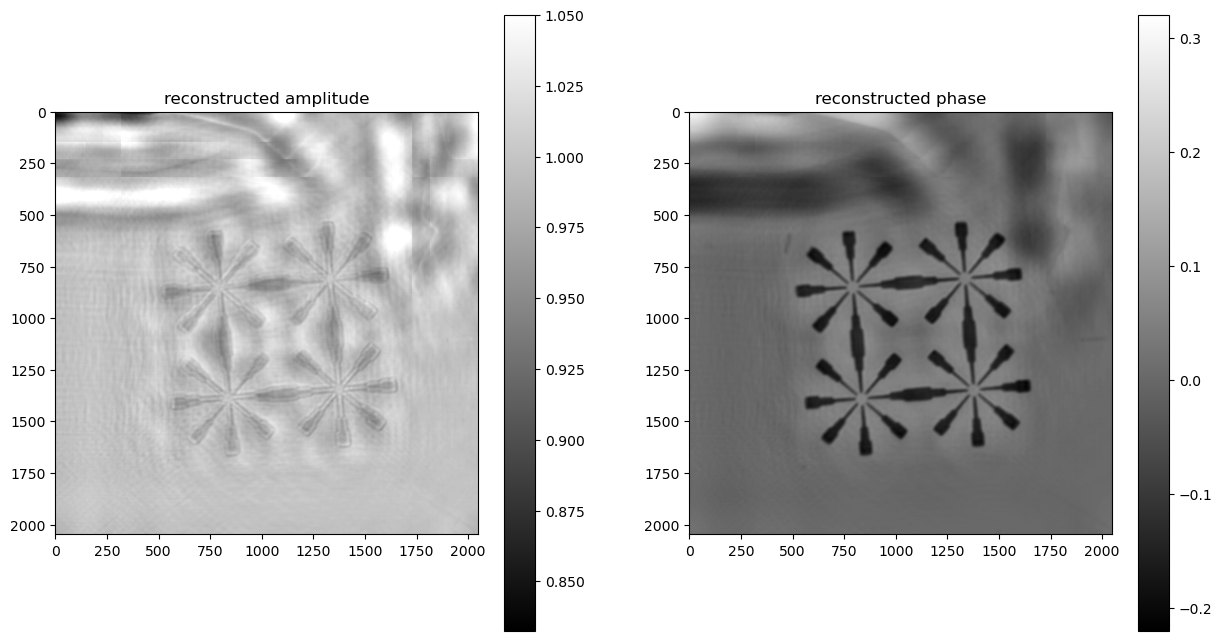

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0]),cmap='gray',vmax=1.05)
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

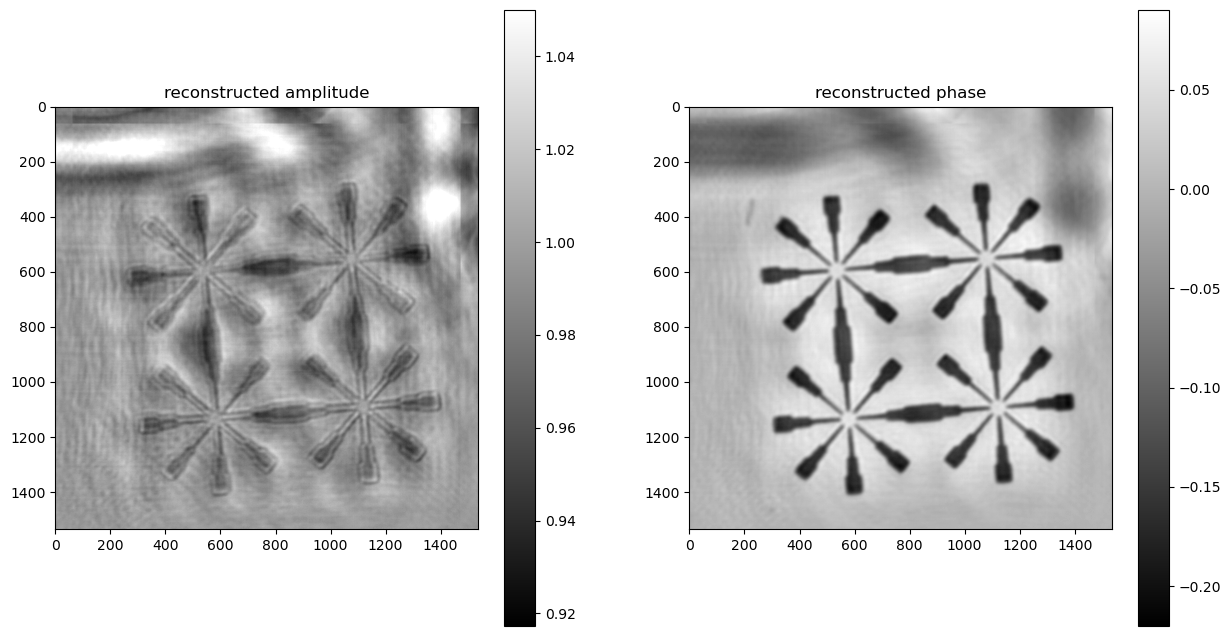

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0,256:-256,256:-256]),cmap='gray',vmax=1.05)
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0,256:-256,256:-256]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

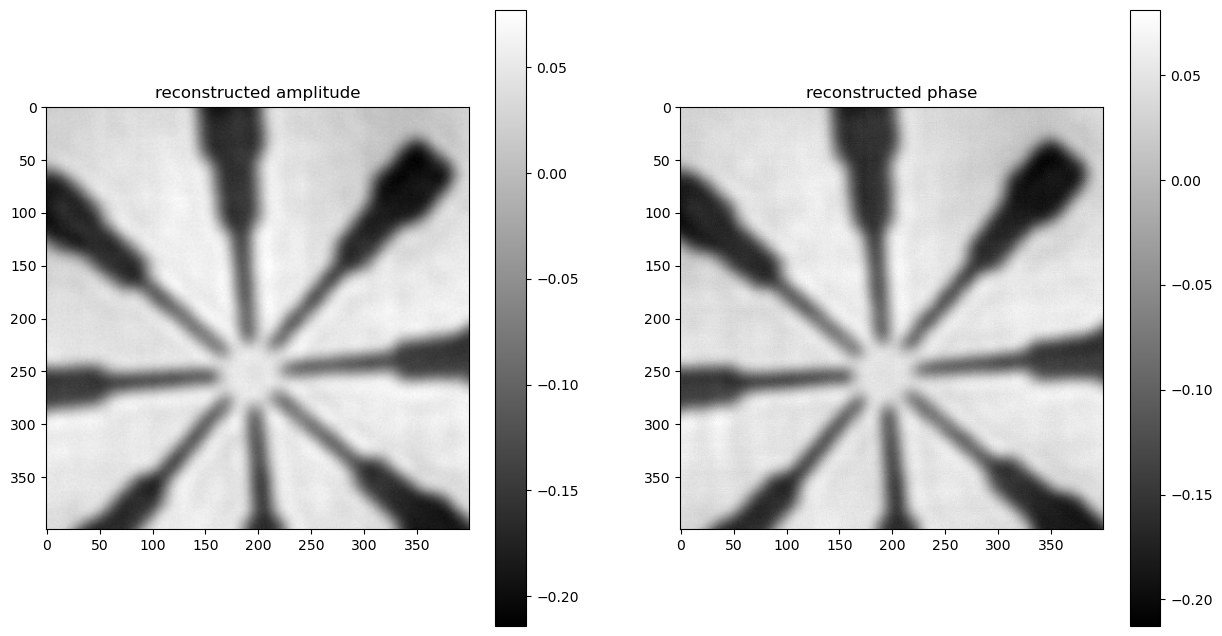

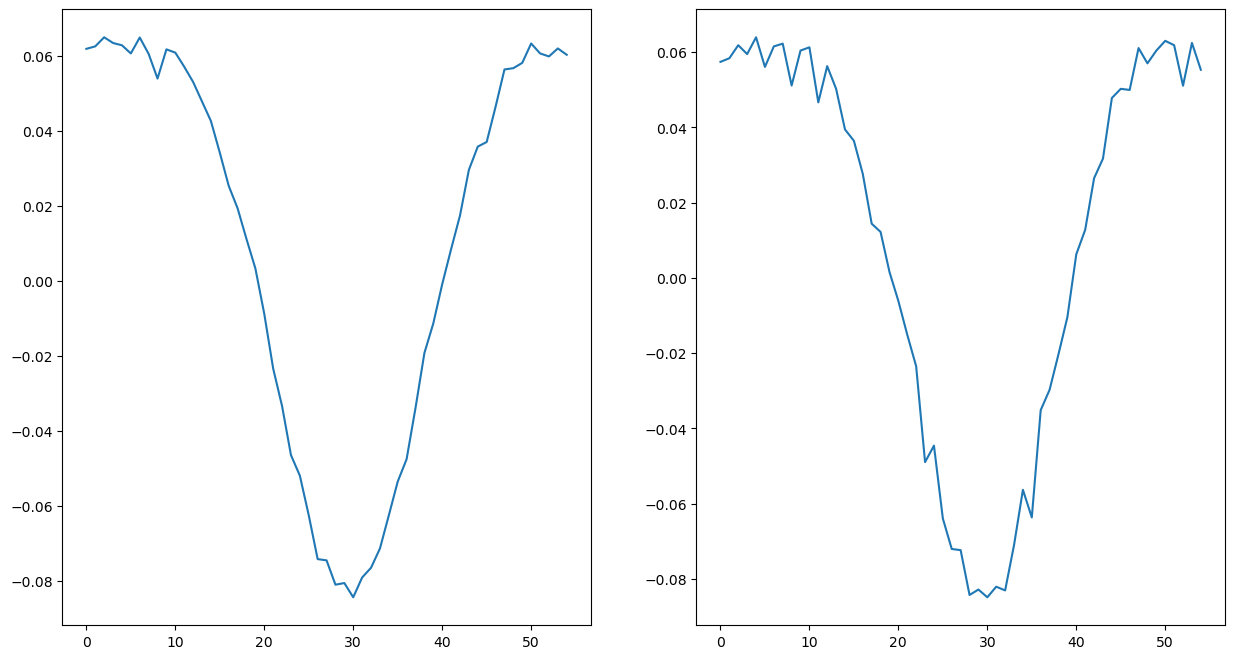

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.angle(rec_scaled[0,600:1000,600:1000]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0,600:1000,600:1000]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].plot(np.angle(rec_scaled[0,600+200,600+160:600+215]))
im=axs[1].plot(np.angle(rec[0,600+200,600+160:600+215]))
